In [1]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'state labels')

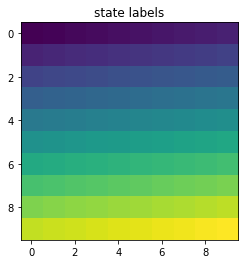

In [6]:
# Start by making an environment of states
x_dim = 10
y_dim = 10

# define the map of the environment - here we're keeping it as an open grid world but you could add walls/barriers here 
state_map = np.zeros([y_dim,x_dim])
n_states = state_map.size

# Give each bin in the environment a unique state id 
state_ids = np.arange(n_states).reshape(y_dim,x_dim)

plt.imshow(state_ids, origin='upper')
plt.title('state labels')

True


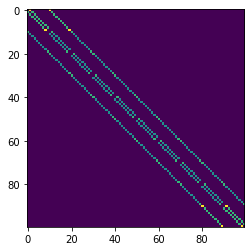

In [7]:
# Two ways to calculate the SR matrix, either the recursive sum of transition matrices or TD learning
# For the recursive sum method, we need a transition matrix so lets use one for a uniform random walk

# Transition matrix defines probability T[i,j] of transitioning from state i to state j 
T_rw = np.zeros([n_states,n_states])

# rule for how to find the state_id of neighbouring states to the North, South, East and West
neighbour_rule = np.array([[1,0], [-1,0], [0,1], [0,-1]]) 

# Now cycle through states and find adjacent bins so we can calculate the probability of uniformly random transitions
for state in range(n_states):
    [coords] = np.argwhere(state_ids == state)
    
    # find neighbouring states
    for i in range(4):
        neighbour_coords = coords + neighbour_rule[i]
        # if transition to neighbouring state is possible mark it in the transition matrix
        if np.all(neighbour_coords < [y_dim, x_dim]) and np.all(neighbour_coords >= 0):
            neighbour_id = state_ids[neighbour_coords[0],neighbour_coords[1]]
            T_rw[state, neighbour_id] = 1 
# Normalise transition matrix to make transition probabilities (i.e. all rows sum to 1)
T_rw = T_rw / T_rw.sum(axis=1).reshape(-1,1)

# Double check all rows sum to 1
print(np.all(T_rw.sum(axis=1) == 1))

# Plot the transition matrix to see what it looks like
plt.imshow(T_rw)

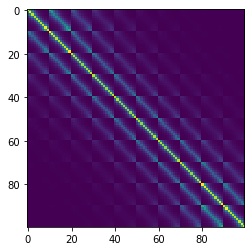

In [9]:
# Now we have T, we can compute the SR matrix M = I + gamma * T + gamma^2 * T^2 + ... etc 
# At first glance this looks tricky (i.e. infinite sum), but can utilise mathematical trick by calculating inverse of (I - gamma*T)
# First we need to specify the discount factor gamma
gamma = 0.9

# Then calculate M
M_rw = np.linalg.inv(np.eye(n_states) - gamma * T_rw)

# Plot successor matrix M to see what it looks like
plt.imshow(M_rw)

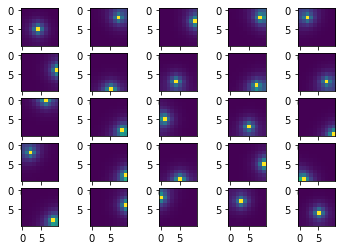

In [10]:
# In the Stachenfeld model place cells correspond to columns of the SR, so lets plot a few
random_states = np.random.randint(n_states,size=25)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(M_rw[:, random_states[i]].reshape(y_dim,x_dim))

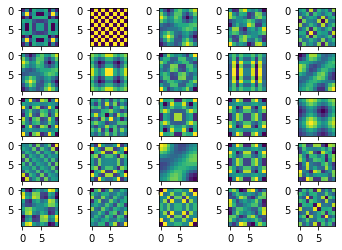

In [11]:
# Similarly, grid cells correspond to eigenvectors of the SR, so lets plot a few of those too
# Calculate eigenvectors V
_, V = np.linalg.eig(M_rw)

random_states = np.random.randint(n_states,size=25)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(V[:,random_states[i]].reshape(y_dim,x_dim))

In [12]:
# The other way of learning the SR matrix M uses temporal-difference (TD) learning
# Along with discount factor gamma, now we also have to specify the learning rate alpha
def td_learning(M, current_state, next_state, alpha=0.2, gamma=0.9):
    # calculate prediciton error delta which describes how suprising the most recent transition was
    delta = (np.arange(n_states) == current_state) + gamma*M[next_state,:] - M[current_state,:]
    # update SR matrix M
    M[current_state,:] = M[current_state,:] + alpha * delta
    
    return M, delta

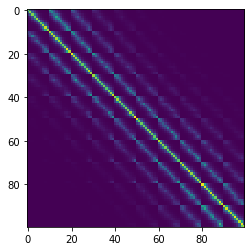

In [13]:
# Generate some behaviour and learn the SR via the TD rule

# initialise parameters
n_timesteps = 10000
M_td = np.eye(n_states)

# initialise somewhere to store the SR prediction errors for each state
deltas = np.zeros((n_timesteps, n_states))

# Choose starting state
state = 0

for n in range(n_timesteps):
    [next_state] = np.random.choice(np.arange(n_states), 1, p=T_rw[state,:])
    M_td, delta = td_learning(M_td, state, next_state)
    deltas[n] = delta 
    state = next_state
      
# Plot successor matrix M to check it looks similar to the true random walk version
plt.imshow(M_td)

Text(0, 0.5, 'prediction error')

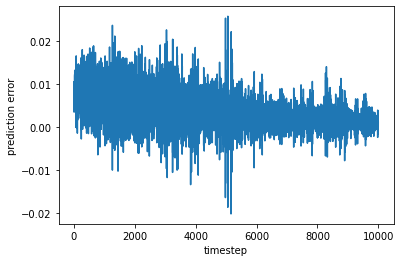

In [9]:
# Hopefully the prediction errors should decay over time!

plt.plot(deltas.mean(axis=1))
plt.xlabel("timestep")
plt.ylabel("prediction error")

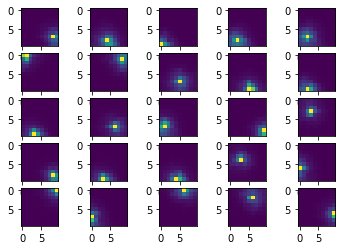

In [10]:
# Again, plot some place cells (i.e. columns of the SR) to see what they look like
random_states = np.random.randint(n_states,size=25)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(M_td[:, random_states[i]].reshape(y_dim,x_dim))

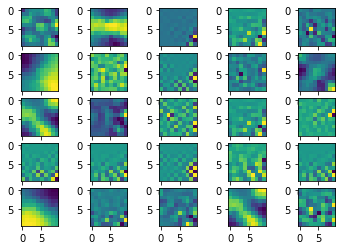

In [11]:
# And do the same for some grid cells (eigenvectors)
_, V = np.linalg.eig(M_td)

# Since M_td approximates M_rw, M_td won't neccesarily be symettric
# This means the eigenvectors will likely contain complex conjugate pairs - we'll take the real components
V = np.real(V) 

random_states = np.random.randint(n_states,size=25)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(V[:,random_states[i]].reshape(y_dim,x_dim))